## Red neuronal de tres capas en Pytorch

Los números utilizados para ejercicio se pueden descargar de:
http://yann.lecun.com/exdb/mnist/

Los archivos descomprimidos deberán de colocarse en la carpeta /mnist/

In [2]:
import numpy as np
import importlib
from decimal import Decimal 

In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
device = torch.device('cuda')

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

In [5]:
from ipywidgets import interact, interact_manual, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

# Datos

Los datos a utilizar son imágenes de dígitos.  En su formato original, se leen dos vectores:
* Los datos de **entrada** vienen en un vector 3D.
  * Cada renglón corresponde a un ejemplar de entrenamiento.
  * En cada renglón hay una matriz 2D con las intensidades de los pixels.
* Las etiquetas (dígito correcto que representan) vienen en un vector de una dimensión.

In [6]:
from mnist.read import read, printFull

filesDir = './mnist/'
trainingSetFile = filesDir + 'train-images.idx3-ubyte'
trainingSetLabelsFile = filesDir + 'train-labels.idx1-ubyte'
testSetFile = filesDir + 't10k-images.idx3-ubyte'
testSetLabelsFile = filesDir + 't10k-labels.idx1-ubyte'


###     /\ |__   __||  ____|| \ | | / ____||_   _|/ __ \ | \ | |
###    /  \   | |   | |__   |  \| || |       | | | |  | ||  \| |
###   / /\ \  | |   |  __|  | . ` || |       | | | |  | || . ` |
###  / ____ \ | |   | |____ | |\  || |____  _| |_| |__| || |\  |
### /_/    \_\|_|   |______||_| \_| \_____||_____|\____/ |_| \_|
### EN LAS SIQUIENTES DOS LINEAS SE LIMITA EL TAMAÑO DE LOS DATOS DE ENTRENAMIENTO,EN CASO
### DE INCREMENTAR LA CANTIDAD EL CALCULO TOMA DRASTICAMENTE MAS TIEMPO EN EL CASO DE APROXIMACION DEL GRADIENTE,SE INCLUYE
### IMPRESION DEL PROGRESO DEL METODO
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('train-images.idx3-ubyte', download=False, train=True, transform=transform)
valset = datasets.MNIST('t10k-images.idx3-ubyte', download=False, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

trainData = read(fileName=trainingSetFile).astype(np.float64)
trainDataLabels = read(fileName=trainingSetLabelsFile).astype(np.float64)

testData = read(fileName=testSetFile).astype(np.float64)
testDataLabels = read(fileName=testSetLabelsFile).astype(np.float64)

('Vector de ', 3, ' dimensiones: ', (60000, 28, 28), ' tipo ', <type 'numpy.uint8'>)
('Vector de ', 1, ' dimensiones: ', (60000,), ' tipo ', <type 'numpy.uint8'>)
('Vector de ', 3, ' dimensiones: ', (10000, 28, 28), ' tipo ', <type 'numpy.uint8'>)
('Vector de ', 1, ' dimensiones: ', (10000,), ' tipo ', <type 'numpy.uint8'>)


In [7]:
import mnist.plot
from mnist.plot import muestraImagen

In [8]:
@interact(
    indice = (0, len(trainData) - 1)
)
def muestraImagenEntrenamiento(indice):
    muestraImagen(trainData, trainDataLabels, indice)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0yOTk5OSwgZGVzY3JpcHRpb249dSdpbmRpY2UnLCBtYXg9NTk5OTkpLCBPdXRwdXQoKSksIF9kb21fY2xhc3Nlcz0odSd3aWTigKY=


Para poder trabajar con la red neuronal, necesitaremos transformar esas entradas, de modo que los valores de las intensidades de los pixeles se encuentren en un solo renglón.  Las entradas a la red neuronal, deberán ser de la forma:
\begin{align}
  X &= \begin{bmatrix}
       x_1^{(1)} ... x_n^{(1)}  \\
       x_1^{(2)} ... x_n^{(2)}  \\
       ...\\
       x_1^{(m)} ... x_n^{(m)}
      \end{bmatrix}
\end{align}
También necesitaremos que las etiquetas formen una matriz donde la única columna distinta de cero, sea la correspondiente al dígito correcto:
\begin{align}
  Y &= \begin{bmatrix}
       0, ..., y_{label_0} = 1 , ... ,0 \\
       ... \\
       0, ..., y_{label_n} = 1 , ... ,0 \\
      \end{bmatrix}
\end{align}


In [9]:
## Define las matrices X y Y, como se muestra arriba
## A partir de trainData y trainDataLabels
## TIP: usar reshape
def makeX(datosEntrenamiento):
    return datosEntrenamiento.reshape((-1, datosEntrenamiento.shape[1], datosEntrenamiento.shape[2], 1))

def makeY(etiquetasEntrenamiento):
    matrix = np.zeros((etiquetasEntrenamiento.shape[0], 10))
    for i in range(etiquetasEntrenamiento.shape[0]):
        matrix[i][int(etiquetasEntrenamiento[i])] = 1
        
    return matrix
    
X = makeX(trainData)
print("X shape=",X.shape)
Y = makeY(trainDataLabels)
print("Y shape=",Y.shape)


('X shape=', (60000, 28, 28, 1))
('Y shape=', (60000, 10))


In [10]:
## Repite lo mismo con los datos de entrenamiento
XTest = makeX(testData)
YTest = makeY(testDataLabels)

## Red con tres capas
La red neuronal que se utilizará es una red neuronal de tres capas:
* Entrada
* Oculta
* Salida
La forma genérica de la red se ilustra a continuación.  Sólo que la red de este ejercicio tendrá más neuronas en cada capa.
<img src="figuras/Red3Capas.png"/>
Para este ejercicio el número de neuronas será:
* 785 + 1 (28x28 pixeles más la unidad de sesgo)
* X + 1 unidades en la capa oculta donde X es elección del diseñador
* 10 neuronas de salida (una por cada dígito)
Por lo tanto, las dimensiones de las matrices de pesos son:
* $\Theta^{(0)} \rightarrow (25 \times 786)$
* $\Theta^{(1)} \rightarrow (10 \times 26)$

In [13]:
## Programa una clase RedNeuronal en PyTorch con la arquitectura anterior.

class NN():
    def __init__(self, input_size, hidden_sizes, output_size):
        self.model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.BatchNorm1d(128),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
        
    def feedForward(self, X):
        return self.model(X)
    
    def backPropagate(self, X, Y):
        criterion = nn.CrossEntropyLoss()
        self.loss = criterion(X, Y)
        self.loss.backward()
        
    def train(self, trainset, NofE=100):
        optimizer = optim.SGD(self.model.parameters(), lr=0.003, momentum=0.9)
        errores = np.zeros(NofE)
        for i in range(NofE):
            running_loss = 0
            
            for images, labels in trainset:
                
                images = images.view(images.shape[0], -1)
    
                optimizer.zero_grad()
        
                output = self.feedForward(images)
                self.backPropagate(output, labels)
        
                optimizer.step()
        
                running_loss += self.loss.item()
            
            errores[i] = running_loss
            
        if NofE > 1:
            plt.plot(np.arange(NofE), errores)
             
    def view_classify(self, img, ps):
        ps = ps.data.numpy().squeeze()

        fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
        ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
        ax1.axis('off')
        ax2.barh(np.arange(10), ps)
        ax2.set_aspect(0.1)
        ax2.set_yticks(np.arange(10))
        ax2.set_yticklabels(np.arange(10))
        ax2.set_title('Probabilidades')
        ax2.set_xlim(0, 1.1)
        plt.tight_layout()
    
    def test(self, testset):
        images, labels = next(iter(valloader))
        img = images[0].view(1, 784)

        with torch.no_grad():
            logps = self.feedForward(img)
    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        print("Prediccion =", probab.index(max(probab)))
        self.view_classify(img.view(1, 28, 28), ps)
    
red = NN(784, [128, 10], 10)
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

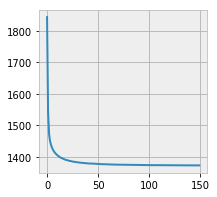

In [14]:
red.train(trainloader, NofE = 150)

('Prediccion =', 5)


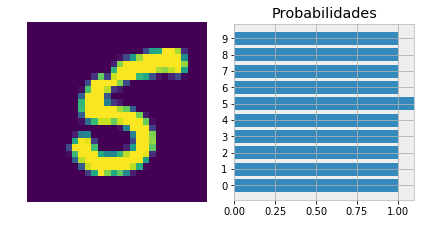

In [43]:
## Prueba el modelo entrenado con los datos de prueba y muestra la métrica de exatitud
red.test(valloader)

In [25]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = red.feedForward(img)

    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
                
        all_count += 1

print("Imagenes probadas =", all_count)
print("Exactitud =", str(float(correct_count) / float(all_count) * 100) + "%")

('Imagenes probadas =', 10000)
('Exactitud =', '97.47%')


In [27]:
## Programa una clase RedNeuronal en PyTorch con la arquitectura anterior.

class NN1():
    def __init__(self, input_size, hidden_sizes, output_size):
        self.model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.BatchNorm1d(128),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
        
    def feedForward(self, X):
        return self.model(X)
    
    def backPropagate(self, X, Y):
        criterion = nn.SmoothL1Loss()
        self.loss = criterion(X, Y)
        self.loss.backward()
        
    def train(self, trainset, NofE=100):
        optimizer = optim.Adagrad(self.model.parameters(), lr=0.01)
        errores = np.zeros(NofE)
        for i in range(NofE):
            running_loss = 0
            
            for images, labels in trainset:
                
                images = images.view(images.shape[0], -1)
    
                optimizer.zero_grad()
        
                output = self.feedForward(images)
                self.backPropagate(output, labels)
        
                optimizer.step()
        
                running_loss += self.loss.item()
            
            errores[i] = running_loss
            
        if NofE > 1:
            plt.plot(np.arange(NofE), errores)
             
    def view_classify(self, img, ps):
        ps = ps.data.numpy().squeeze()

        fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
        ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
        ax1.axis('off')
        ax2.barh(np.arange(10), ps)
        ax2.set_aspect(0.1)
        ax2.set_yticks(np.arange(10))
        ax2.set_yticklabels(np.arange(10))
        ax2.set_title('Probabilidades')
        ax2.set_xlim(0, 1.1)
        plt.tight_layout()
    
    def test(self, testset):
        images, labels = next(iter(valloader))
        img = images[0].view(1, 784)

        with torch.no_grad():
            logps = self.feedForward(img)
    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        print("Prediccion =", probab.index(max(probab)))
        self.view_classify(img.view(1, 28, 28), ps)
    
red = NN1(784, [128, 10], 10)
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

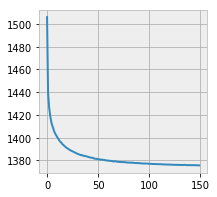

In [25]:
red.train(trainloader, NofE = 150)

In [ ]:
red.test(valloader)

In [28]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = red.feedForward(img)

    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
                
        all_count += 1

print("Imagenes probadas =", all_count)
print("Exactitud =", str(float(correct_count) / float(all_count) * 100) + "%")

('Imagenes probadas =', 10000)
('Exactitud =', '5.84%')


In [31]:
## Programa una clase RedNeuronal en PyTorch con la arquitectura anterior.

class NN2():
    def __init__(self, input_size, hidden_sizes, output_size):
        self.model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.BatchNorm1d(128),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
        
    def feedForward(self, X):
        return self.model(X)
    
    def backPropagate(self, X, Y):
        criterion = nn.MSELoss()
        self.loss = criterion(X, Y)
        self.loss.backward()
        
    def train(self, trainset, NofE=100):
        optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        errores = np.zeros(NofE)
        for i in range(NofE):
            running_loss = 0
            
            for images, labels in trainset:
                
                images = images.view(images.shape[0], -1)
    
                optimizer.zero_grad()
        
                output = self.feedForward(images)
                self.backPropagate(output, labels)
        
                optimizer.step()
        
                running_loss += self.loss.item()
            
            errores[i] = running_loss
            
        if NofE > 1:
            plt.plot(np.arange(NofE), errores)
             
    def view_classify(self, img, ps):
        ps = ps.data.numpy().squeeze()

        fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
        ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
        ax1.axis('off')
        ax2.barh(np.arange(10), ps)
        ax2.set_aspect(0.1)
        ax2.set_yticks(np.arange(10))
        ax2.set_yticklabels(np.arange(10))
        ax2.set_title('Probabilidades')
        ax2.set_xlim(0, 1.1)
        plt.tight_layout()
    
    def test(self, testset):
        images, labels = next(iter(valloader))
        img = images[0].view(1, 784)

        with torch.no_grad():
            logps = self.feedForward(img)
    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        print("Prediccion =", probab.index(max(probab)))
        self.view_classify(img.view(1, 28, 28), ps)
    
red3 = NN2(784, [128, 64], 10)
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

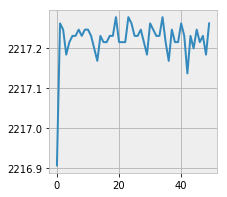

In [32]:
red3.train(trainloader, NofE = 150)

In [33]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = red.feedForward(img)

    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
                
        all_count += 1

print("Imagenes probadas =", all_count)
print("Exactitud =", str(float(correct_count) / float(all_count) * 100) + "%")

('Imagenes probadas =', 10000)
('Exactitud =', '11.05%')
